In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.metrics import ndcg_score
from joblib import load

In [6]:
# 1.2 Cargar dataset preprocesado (merge ya realizado)
df = pd.read_csv("C:/Users/josen/Documents/MASTER/TFM/SmartLifter.csv")

In [7]:
# 1.3 Comprobar valores nulos
print("Valores nulos por columna:\n", df.isnull().sum())

Valores nulos por columna:
 user_id            0
Type_x             0
Level_x            0
exercise_id        0
Age                0
Gender             0
Weight_kg          0
Height_m           0
Workout_time       0
Calories_Burned    0
Type_y             0
Fat_Percentage     0
Frequency          0
Level_y            0
BMI                0
Title              0
Type               0
BodyPart           0
Equipment          0
Level              0
BodyGroup          0
dtype: int64


In [8]:
# 1.4 Estadísticos básicos
print("\nDescripción numérica:\n", df.describe())


Descripción numérica:
              user_id    exercise_id            Age      Weight_kg  \
count  292392.000000  292392.000000  292392.000000  292392.000000   
mean      465.089171    1434.016731      39.624248      72.881554   
std       272.527442     863.799896      12.228511      22.253356   
min         2.000000       0.000000      18.000000      40.000000   
25%       232.000000     651.000000      28.000000      55.700000   
50%       460.000000    1436.000000      41.000000      68.700000   
75%       656.000000    2227.000000      50.000000      82.100000   
max       972.000000    2917.000000      59.000000     129.500000   

            Height_m   Workout_time  Calories_Burned  Fat_Percentage  \
count  292392.000000  292392.000000    292392.000000   292392.000000   
mean        1.721150       1.224012       884.089301       27.486263   
std         0.122348       0.173627       157.823694        4.036095   
min         1.500000       0.510000       303.000000       20.0000

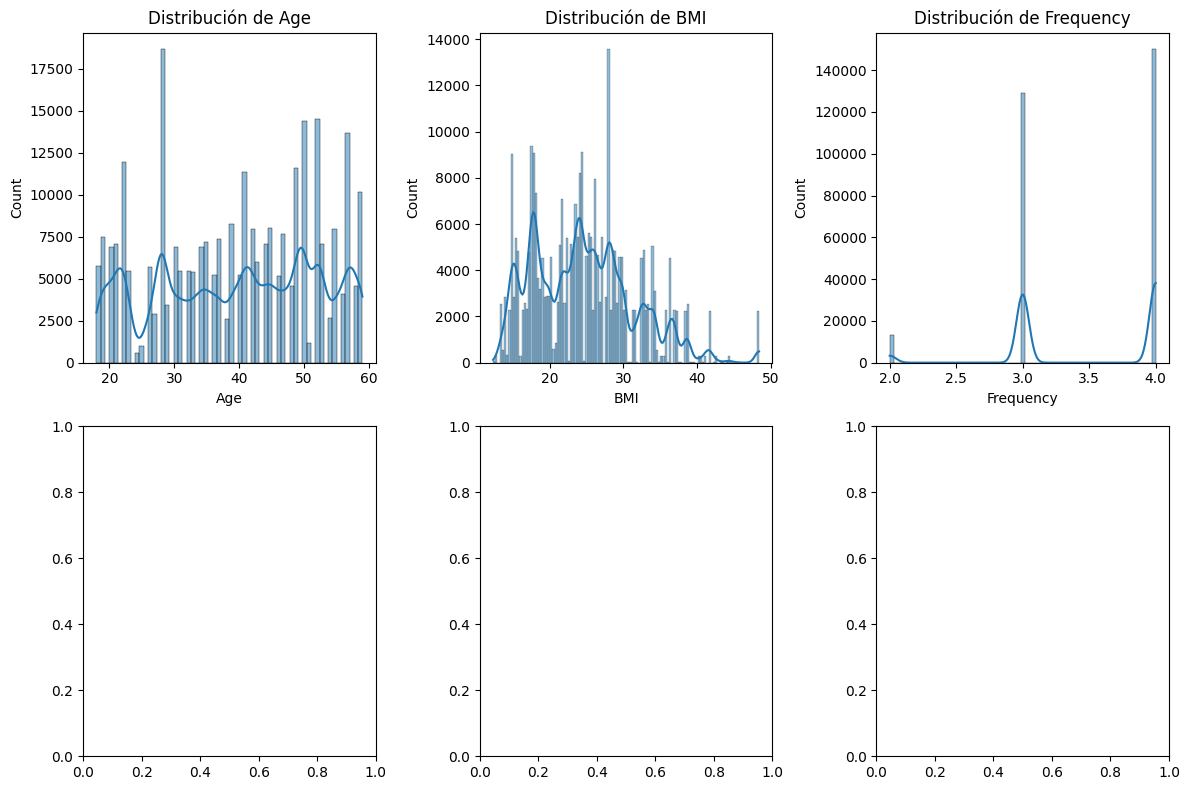

In [9]:
# 1.5 Distribuciones de variables clave
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, col in zip(axes.flat, ["Age","BMI","Frequency"]):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

In [10]:
# 1.6 Detección simple de outliers (IQR) en Age y BMI
for col in ["Age","BMI"]:
    Q1, Q3 = df[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    print(f"{col}: {mask.sum()} outliers detectados")

Age: 0 outliers detectados
BMI: 2631 outliers detectados


In [11]:
# 1.7 Winsorización de BMI al percentil 1–99
p_low, p_high = df['BMI'].quantile([0.01, 0.99])
df['BMI'] = df['BMI'].clip(lower=p_low, upper=p_high)

In [12]:
# Verificamos que ya no haya outliers según IQR
Q1, Q3 = df['BMI'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = ((df['BMI'] < Q1 - 1.5*IQR) | (df['BMI'] > Q3 + 1.5*IQR)).sum()
print(f"Outliers BMI tras winsorización: {outliers}")

Outliers BMI tras winsorización: 0


In [13]:
# 2.1. Creamos un map de Level a numérico para poder interactuar
level_map = {"Beginner": 1, "Intermediate": 2, "Advanced": 3}
df["Level_num"] = df["Level"].map(level_map)

In [14]:
# 2.2. Feature de interacción Age × Level
df["Age_x_Level"] = df["Age"] * df["Level_num"]

In [15]:
# 2.3. Categorías de BMI (Underweight, Normal, Overweight, Obese)
bins = [0, 18.5, 25, 30, np.inf]
labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["BMI_cat"] = pd.cut(df["BMI"], bins=bins, labels=labels)

In [16]:
# 2.4. Frecuencia semanal en categorías (Low, Medium, High)
freq_bins = [0, 2, 4, np.inf]
freq_labels = ["Low", "Medium", "High"]
df["Freq_cat"] = pd.cut(df["Frequency"], bins=freq_bins, labels=freq_labels)

In [17]:
# 2.5. Codificar las nuevas categóricas con LabelEncoder
from sklearn.preprocessing import LabelEncoder
for col in ["BMI_cat", "Freq_cat"]:
    le = LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])

In [18]:
# 2.6. Limpiar columna auxiliar
df.drop("Level_num", axis=1, inplace=True)

# 2.7. Vista rápida de las nuevas features
df[["Age", "Level", "Age_x_Level", "BMI", "BMI_cat", "Frequency", "Freq_cat"]].head()

,Age,Level,Age_x_Level,BMI,BMI_cat,Frequency,Freq_cat
0,32,Intermediate,64,24.71,0,4,1
1,32,Intermediate,64,24.71,0,4,1
2,32,Intermediate,64,24.71,0,4,1
3,32,Intermediate,64,24.71,0,4,1
4,32,Intermediate,64,24.71,0,4,1


In [19]:
# 3) Definir X e y
features = ["Age","Gender","BMI","Type","Level","Age_x_Level","BMI_cat","Freq_cat"]
X = df[features].copy()
y = df["Frequency"]

In [20]:
# 4) Codificar variables categóricas
for col in ["Gender","Type","Level","BMI_cat","Freq_cat"]:
    X[col] = LabelEncoder().fit_transform(X[col])

In [21]:
# 5) División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# 6) Pipeline: escalado + XGBRegressor con regularización
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        verbosity=0,
        eval_metric='rmse'
    ))
])

In [23]:
# 7) Espacio de búsqueda de hiperparámetros acotado para evitar overfitting
param_dist = {
    "xgb__n_estimators":       [50, 100, 150],
    "xgb__max_depth":          [3, 4, 5],
    "xgb__learning_rate":      [0.01, 0.05, 0.1],
    "xgb__subsample":          [0.8, 1.0],
    "xgb__colsample_bytree":   [0.8, 1.0],
    "xgb__reg_alpha":          [0.1, 1.0, 10.0],
    "xgb__reg_lambda":         [0.1, 1.0, 10.0]
}

In [24]:
# 8) Configurar RandomizedSearch con 5-fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_squared_error",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [25]:
# 9) Realizar la búsqueda
search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric='rmse',
                                                           feature_types...
                                                           num_parallel_tree=None, ...))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.8, 1.0],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1],
                                        'xgb__max_depth': [3, 4, 5],
                                        'xgb__n_estimators': [50, 100, 150],
                                        'xgb__reg_alpha': [0.1, 1.0, 10.0],
                                        'xgb__reg_lambda': [0.1, 1.0, 10.0],
                                        'xgb__subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [26]:
# 10) Extraer el mejor modelo
best_model = search.best_estimator_

In [27]:
import xgboost as xgb

# 11) Reentrenar el mejor modelo con early stopping usando callbacks
eval_set = [(best_model.named_steps['scaler'].transform(X_test), y_test)]
callbacks = [xgb.callback.EarlyStopping(rounds=10, save_best=True)]

In [28]:
# 12) Evaluar el modelo
y_pred = best_model.predict(X_test)
print("MSE en test:", mean_squared_error(y_test, y_pred))
print("R² en test:", r2_score(y_test, y_pred))

# 13) Guardar el modelo
joblib.dump(best_model, "xgb_frequency_model_regularizado.pkl")

MSE en test: 0.002923334715887904
R² en test: 0.9913605451583862


['xgb_frequency_model_regularizado.pkl']

In [29]:
# 2) Carga pipeline entrenado
model = load("xgb_frequency_model_regularizado.pkl")

In [30]:
# 3) Create test pairs and predict scores
# Use the test set (X_test) that was created during train-test split
test_pairs = X_test.copy()
Xf = ["Age","Gender","BMI","Type","Level","Age_x_Level","BMI_cat","Freq_cat"]
test_pairs["score"] = model.predict(test_pairs[Xf])

In [31]:
# 4) Métricas @5
def precision_at_k(ranked, relevant, k=5):
    return len(set(ranked[:k]) & set(relevant)) / k

def recall_at_k(ranked, relevant, k=5):
    return len(set(ranked[:k]) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(ranked, relevant, k=5):
    y_true = np.array([[1 if ex in relevant else 0 for ex in ranked[:k]]])
    y_score = np.array([ranked[:k]])  # o simplemente los propios 1/0
    return ndcg_score(y_true, y_true, k=k)

ums = []
# Since we don't have user_id, we'll treat each exercise group as a "group" 
for grp_name, grp in test_pairs.groupby("Type"):
    ranked = grp.sort_values("score", ascending=False).index.tolist()
    # Consider exercises with above median score as relevant
    relevant = grp[grp["score"] > grp["score"].median()].index.tolist()
    if not relevant: continue
    ums.append({
        "group": grp_name,
        "prec@5": precision_at_k(ranked, relevant),
        "rec@5": recall_at_k(ranked, relevant),
        "ndcg@5": ndcg_at_k(ranked, relevant)
    })

um = pd.DataFrame(ums)
print("Precision@5 medio:", um["prec@5"].mean())
print("Recall@5 medio:   ", um["rec@5"].mean())
print("NDCG@5 medio:     ", um["ndcg@5"].mean())

Precision@5 medio: 1.0
Recall@5 medio:    0.007011919975718657
NDCG@5 medio:      1.0
